In [1]:
import numpy as np
import pickle
import scipy.ndimage
import matplotlib.pyplot as plt
import math

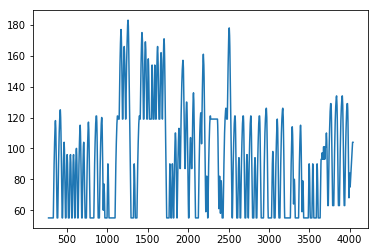

In [2]:
tracks = pickle.load(open("tracks.pkl"))

tracksToKeep=['track2']
kept = []
    

for track in sorted(tracks[1]):
    trackID = track[0]
    trackDict = track[1]
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
    
for trackID in sorted(tracks[0]):
    track = tracks[0][trackID]
    trackDict = track
    trackDat = []
    for t in sorted(trackDict):
        trackDat.append([t] + list(trackDict[t][1]))
    trackDat = np.array(trackDat)
    if trackID in tracksToKeep:
        kept.append(trackDat)
    #plt.plot(trackDat[:,0],256-trackDat[:,2])
    #plt.show()
track = np.vstack(kept)
track = track
plt.plot(track[:,0],256-track[:,2])
plt.show()


In [3]:
def jumps(vals):
    
    return [t for t in range(1,len(vals)) if  np.abs(vals[t]-vals[t-1]) > 1]

def samey_intervals(vals, t_window=5):
    last = vals[0]
    start = -1
    accum = 0
    intervals = []
    
    for t, v in enumerate(vals):
        
        if v != last:
            accum += 1
            
        if last == v:
            accum = 0
            
        if accum > 1:
            last = v
            
            if (t-accum)-start > t_window:
                intervals.append(start+1)
                intervals.append(t-accum)
                intervals.append(t-accum+1)

            start = t-accum
            accum = 0

    return intervals


def zero_crossings(vals):    

    sign_intervals = []
    last_sign_change = 0
    vsigns = np.sign(vals)
    last_sign = vsigns[0]    
    zeros = np.zeros(vsigns.shape)
    zeros[vsigns == 0] = 1
    accum = 0

    for t in range(len(zeros)):        
        if zeros[t] == 1:
            accum += 1
        else:
            accum = 0
        zeros[t] = accum
    last = 0

    for t,v in enumerate(zeros):
        if v == 1:
            sign_intervals.append(t)
        elif v == 0 and last > 5:
            sign_intervals.append(t-1)
        last = v

    return sorted(set(sign_intervals))

640


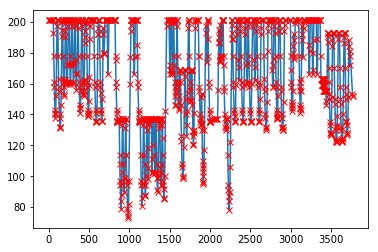

In [4]:
axis = 2

velocities = track[1:,axis]-track[:-1,axis] 

same_window = 6

switch_points = set(zero_crossings(velocities))

samey_points = set(samey_intervals(velocities,t_window=same_window))

velocity_times = sorted(switch_points | samey_points | set(jumps(velocities)))

print len(velocity_times)

plt.plot(track[:,2])
plt.plot(np.array(velocity_times),track[np.array(velocity_times,dtype='int'),2],'rx')


import fceulib
inputVec = fceulib.readInputs('movie.fm2')

def button_change_times(button_masks):
    last_mask = 0
    mask_times = []
    # Note: for a temporary optimization we could drop certain buttons?
    for t, b in enumerate(button_masks):
        if t < track[0,0]:
            continue
        if t > track[-1,0]:
            break
        if b != last_mask:
            mask_times.append(t-track[0,0])
            last_mask = b
    return mask_times

button_times = button_change_times(inputVec)
all_times = sorted(set(button_times) | set(velocity_times))
plt.plot(np.array(button_times),track[np.array(button_times),axis],'rx')
plt.show()

In [5]:
def make_inputs(start,end,input_type):
    end = all_times[end]
    start = all_times[start]
    interval = end-start
    data = np.zeros((interval,1))
    
    vels = np.copy(velocities[start:end])
    if input_type in ['cN','accN']:
        data = np.hstack((data,np.ones((interval,1))))
    if input_type in ['acc0','accP','accN']:
        dat = np.ones((interval,1))
        for ii in range(interval):
            dat[ii,0] = ii
            
        data = np.hstack((data,dat))
    if input_type in ['accP','cP']:
        begin = velocities[start-1]
        vels -= begin
    return data, vels

Points: 817
[0, 8, 12, 33, 58, 59, 61, 65, 71, 72, 80, 81, 82, 84, 93, 104, 105, 113, 114, 120, 125, 127, 128, 136, 137, 143, 144, 154, 165, 166, 167, 168, 173, 174, 180, 185, 186, 187, 190, 192, 198, 199, 206, 207, 208, 209, 212, 214, 215, 223, 228, 230, 238, 244, 245, 248, 255, 256, 262, 264, 269, 271, 279, 285, 286, 293, 294, 302, 307, 309, 317, 323, 324, 328, 335, 338, 344, 352, 359, 360, 361, 362, 366, 367, 373, 379, 380, 386, 387, 390, 399, 409, 410, 416, 417, 423, 429, 430, 433, 434, 435, 439, 441, 442, 448, 449, 450, 451, 452, 458, 468, 469, 475, 481, 482, 490, 491, 493, 495, 496, 497, 501, 504, 505, 511, 513, 514, 523, 524, 538, 550, 560, 561, 567, 573, 574, 582, 583, 588, 589, 590, 594, 604, 612, 613, 614, 622, 629, 630, 636, 642, 643, 645, 651, 652, 657, 658, 667, 677, 678, 686, 688, 689, 697, 714, 723, 724, 725, 735, 748, 755, 780, 812, 815, 823, 824, 830, 831, 836, 837, 845, 846, 851, 852, 853, 854, 857, 858, 874, 875, 881, 883, 887, 888, 893, 897, 904, 906, 908, 915, 916,

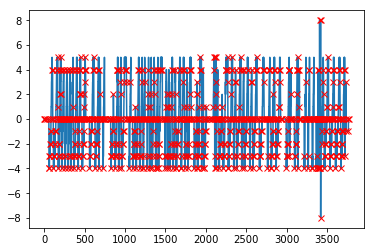

0
1
2


/usr/lib/python2.7/dist-packages/statsmodels/tools/tools.py:382: RuntimeWarning: invalid value encountered in divide
  return int(np.add.reduce(np.greater(D / D.max(), cond).astype(np.int32)))


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278


In [6]:
%%time
import statsmodels.api as sm

all_times = [t for t in all_times if (t >= 0 and t < len(velocities))]

likes = [None]*len(all_times)

print "Points:",len(all_times)
print all_times
plt.plot(velocities[:all_times[-1]])
plt.plot(np.array(all_times),velocities[np.array(all_times,dtype='int')],'rx')
plt.show()

# Takahashi Meijin constant, 60 frames / 16 inputs ~= 4 frames per input.
# But note that in general transitions may happen more frequently due to collisions, etc.
min_interval = 1 
max_interval = 5*60
likes = [None]*len(all_times)
for i in range(0,len(all_times)):
    print i
    likes[i] = [None]*len(all_times)
    t0 = all_times[i]
    min_likelihood = float('inf')
    for j in [j for j in range(i+1, len(all_times)) if all_times[j]-all_times[i] > min_interval and  all_times[j]-all_times[i] < max_interval]:
        models = {}
        if all_times[j]-all_times[i] > 1:
            for model in ['c0','cN','acc0','accN']:
                X,Y = make_inputs(i,j,model)
                ols = sm.OLS(Y,X,hasconst=False)
                results = ols.fit()
                models[model] = results
        likes[i][j] = models

#print ''

In [7]:
from scipy import stats

inp = []
def penalty(length,params):
    penalty_type = 'BIC' # 'BIC'
    if penalty_type == 'MDL':
        return 2*(1.0 + 0.5*np.log(length))*len(params)
    if penalty_type == 'BIC':
        return 2*np.log(length)*len(params)
    if penalty_type == 'MDL_Variable':
        K = stats.sem(inp)
        for ii in range(len(K)):
            if K[ii] == 0.0:
                return 2*len(K)
            else:
                k = np.abs(np.round(params[ii]/K[ii]))
                if k <= 1.0:
                    return 2.0*len(K)
                K[ii] = k
        
        return 2*(2+np.sum(np.log(K))+np.sum(np.log(np.log(K))))
    

In [8]:
%%time
modes = [(0,None)]*(len(all_times))
        
    
str_out = ''
for j in range(1, len(all_times)):
    least = float("inf")
    least_template = None
    for i in range(0, j):
        data = likes[i][j]
        if data:
            for model_type,model in data.items():
                crit = model.bic
                if crit < 0:
                    #print 'A',(all_times[j]-all_times[i]),np.log(all_times[j]-all_times[i])*len(model.params)
                    crit = -1*(all_times[j]-all_times[i]) + np.log(all_times[j]-all_times[i])*len(model.params)
                crit2 = model.model.loglike(model.params)
                m_prev = modes[i][0]
                inp,_ = make_inputs(i,j,model_type)
                cost = penalty(all_times[-1]-all_times[0],model.params)
                here = crit + m_prev + cost
                str_out += '{}, {}, {}, {}, {}, {}, {}\n'.format(all_times[i], all_times[j], crit2,crit, cost,here,least)
                if here < least:
                    
                    least = here
                    # prev_i,this_j,t0,t1,name,summary,criterion
                    least_template = (i,j,(model_type,model))
    
                   
    modes[j] = (least, least_template)
    
with open('temp.txt','wb') as outfile:
    outfile.write(str_out)


/usr/lib/python2.7/dist-packages/statsmodels/regression/linear_model.py:502: RuntimeWarning: divide by zero encountered in log
  (self.endog - np.dot(self.exog,params)))) -\


CPU times: user 15.6 s, sys: 24 ms, total: 15.6 s
Wall time: 15.6 s


In [9]:

def get_path(modes):
    mj = len(modes)-1
    path = [modes[mj]]
    while mj > 0:
        mj = modes[mj][1][0]
        path.append(modes[mj])
    return list(reversed(path))[1:]

path = get_path(modes)
for ii,p in enumerate(path):
    print ii,p[0],'\n',all_times[p[1][0]],all_times[p[1][1]],p[1][2][1].params,'\n'

0 -38.4543941407 
0 59 [ 0.] 

1 33.4860474798 
59 84 [ 0.         -4.06153846  0.12846154] 

2 74.7314778171 
84 93 [ 0.          0.40196078] 

3 113.344029773 
93 105 [ 0.          4.08333333] 

4 123.009322766 
105 114 [ 0.] 

5 208.024885391 
114 144 [ 0.         -4.01075269  0.11568409] 

6 244.509105397 
144 154 [ 0.          0.33684211] 

7 290.397462048 
154 167 [ 0.          4.15384615] 

8 313.109298885 
167 174 [ 0.] 

9 461.576909223 
174 209 [ 0.         -4.99047619  0.29355742] 

10 473.836737108 
209 215 [ 0.] 

11 586.440533258 
215 245 [ 0.         -4.97419355  0.34304783] 

12 594.306496946 
245 256 [ 0.] 

13 706.910293096 
256 286 [ 0.         -4.97419355  0.34304783] 

14 717.457803053 
286 294 [ 0.] 

15 830.061599203 
294 324 [ 0.         -4.97419355  0.34304783] 

16 843.91596198 
324 328 [ 0.] 

17 962.179378871 
328 360 [ 0.         -5.10227273  0.32716276] 

18 984.891215708 
360 367 [ 0.] 

19 1053.72594142 
367 390 [ 0.         -4.11956522  0.13735178] 

20

In [10]:
cross = {}

for ii,mode in enumerate(path):
    model1 = mode[1][2][1]
    model1_type = mode[1][2][0]
    model1_params = model1.params
    model1 = model1.model
    for jj,mode2 in enumerate(path):
        model2 = mode2[1][2][1]
        model2_type = mode2[1][2][0]
        model2_params = model2.params
        model2 = model2.model
        if model1_type == model2_type:
            crit = -model2.loglike(0.5*(model1_params+model2_params))
            if crit == float('-inf'):
                crit = -1*(all_times[mode[1][1]]-all_times[mode[1][0]])
        else:
            crit = float('inf')
        cross[(ii,jj)] = crit

In [11]:
"""UnionFind.py

Union-find data structure. Based on Josiah Carlson's code,
http://aspn.activestate.com/ASPN/Cookbook/Python/Recipe/215912
with significant additional changes by D. Eppstein.
"""

class UnionFind:
    """Union-find data structure.

    Each unionFind instance X maintains a family of disjoint sets of
    hashable objects, supporting the following two methods:

    - X[item] returns a name for the set containing the given item.
      Each set is named by an arbitrarily-chosen one of its members; as
      long as the set remains unchanged it will keep the same name. If
      the item is not yet part of a set in X, a new singleton set is
      created for it.

    - X.union(item1, item2, ...) merges the sets containing each item
      into a single larger set.  If any item is not yet part of a set
      in X, it is added to X as one of the members of the merged set.
    """

    def __init__(self):
        """Create a new empty union-find structure."""
        self.weights = {}
        self.parents = {}

    def __getitem__(self, object):
        """Find and return the name of the set containing the object."""

        # check for previously unknown object
        if object not in self.parents:
            self.parents[object] = object
            self.weights[object] = 1
            return object

        # find path of objects leading to the root
        path = [object]
        root = self.parents[object]
        while root != path[-1]:
            path.append(root)
            root = self.parents[root]

        # compress the path and return
        for ancestor in path:
            self.parents[ancestor] = root
        return root
        
    def __iter__(self):
        """Iterate through all items ever found or unioned by this structure."""
        return iter(self.parents)

    def union(self, *objects):
        """Find the sets containing the objects and merge them all."""
        roots = [self[x] for x in objects]
        heaviest = max([(self.weights[r],r) for r in roots])[1]
        for r in roots:
            if r != heaviest:
                self.weights[heaviest] += self.weights[r]
                self.parents[r] = heaviest

In [12]:

unions = UnionFind()
for d in sorted(cross):
    
    t1 = all_times[path[d[0]][1][1]]-all_times[path[d[0]][1][0]]
    t2 = all_times[path[d[1]][1][1]]-all_times[path[d[1]][1][0]]
    
    good = True
    for t in [cross[d], cross[(d[0],d[0])], cross[(d[1],d[1])], cross[(d[1],d[0])]]:
        if t == float('inf'):
            good = False
    if not good:
        continue
        
    inp1,_ = make_inputs(path[d[0]][1][0],path[d[0]][1][1],path[d[0]][1][2][0])
    inp2,_ = make_inputs(path[d[1]][1][0],path[d[1]][1][1],path[d[0]][1][2][0])
    
    inp = inp1
    complexityWeight = penalty(t1,path[d[0]][1][2][1].params)
    inp = inp2
    complexityWeight += penalty(t2,path[d[1]][1][2][1].params)
    
    inp = np.vstack((inp1,inp2))
    joinedWeight =  penalty(t1+t2,0.5*(path[d[0]][1][2][1].params+path[d[1]][1][2][1].params))
    print d, complexityWeight, joinedWeight
    #print path[d[0]][1][2][1].params,path[d[1]][1][2][1].params
    #print min(cross[d] + cross[(d[0],d[0])],cross[(d[1],d[1])]+cross[(d[1],d[0])]),joinedWeight, (cross[(d[0],d[0])]+cross[(d[1],d[1])]) , complexityWeight 
    
    joined = min(cross[d] + cross[(d[0],d[0])],cross[(d[1],d[1])]+cross[(d[1],d[0])]) +joinedWeight
    #print complexityWeight,joinedWeight
    if (joined <= (cross[(d[0],d[0])]+cross[(d[1],d[1])]) +complexityWeight):
        unions.union(d[0],d[1])
        
merged = {}
for u in unions:
    if unions[u] not in merged:
        merged[unions[u]] = set()
    merged[unions[u]].add(u)
print len(merged)
for m in merged:
    print m, merged[m]

(0, 0) 16.3101497756 9.54136924893
(0, 4) 12.5495240425 8.43901541035
(0, 8) 12.0468951859 8.37930948405
(0, 10) 11.7385938263 8.34877453979
(0, 12) 12.9508654334 8.4969904841
(0, 14) 12.3139579712 8.40938523878
(0, 16) 10.9276636101 8.28626945278
(0, 18) 12.0468951859 8.37930948405
(0, 22) 12.0468951859 8.37930948405
(0, 24) 13.8215015759 8.66146668057
(0, 27) 15.8553700912 9.32687818822
(0, 31) 13.7002523323 8.63497622707
(0, 35) 14.8194839082 8.93181623731
(0, 38) 16.8165415684 9.81054955688
(0, 40) 13.8215015759 8.66146668057
(0, 43) 10.9276636101 8.28626945278
(0, 45) 10.9276636101 8.28626945278
(0, 49) 15.0230492968 8.99961934066
(0, 52) 14.2441197633 8.76405326935
(0, 54) 11.3739507127 8.31776616672
(0, 57) 11.3739507127 8.31776616672
(0, 59) 11.7385938263 8.34877453979
(0, 61) 14.5111825485 8.83768121559
(0, 64) 13.1248881874 8.52535975408
(0, 67) 11.7385938263 8.34877453979
(0, 69) 12.9508654334 8.4969904841
(0, 71) 9.54136924893 8.22174772835
(0, 74) 14.9574696511 8.977272739

{4: 0, 5: 1, 6: 2, 7: 3, 173: 4, 50: 5}
0 59 0 c0 [ 0.]
59 84 1 accN [ 0.         -4.50723981  0.21793156]
84 93 2 acc0 [ 0.          0.31345706]
93 105 3 cN [ 0.          4.15133142]
105 114 0 c0 [ 0.]
114 144 1 accN [ 0.         -4.50723981  0.21793156]
144 154 2 acc0 [ 0.          0.31345706]
154 167 3 cN [ 0.          4.15133142]
167 174 0 c0 [ 0.]
174 209 1 accN [ 0.         -4.50723981  0.21793156]
209 215 0 c0 [ 0.]
215 245 1 accN [ 0.         -4.50723981  0.21793156]
245 256 0 c0 [ 0.]
256 286 1 accN [ 0.         -4.50723981  0.21793156]
286 294 0 c0 [ 0.]
294 324 1 accN [ 0.         -4.50723981  0.21793156]
324 328 0 c0 [ 0.]
328 360 1 accN [ 0.         -4.50723981  0.21793156]
360 367 0 c0 [ 0.]
367 390 1 accN [ 0.         -4.50723981  0.21793156]
390 399 2 acc0 [ 0.          0.31345706]
399 410 3 cN [ 0.          4.15133142]
410 417 0 c0 [ 0.]
417 452 1 accN [ 0.         -4.50723981  0.21793156]
452 469 0 c0 [ 0.]
469 493 1 accN [ 0.         -4.50723981  0.21793156]
493 514 

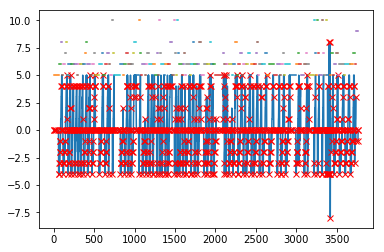

In [13]:
all_times2 = all_times[:]
plt.plot(velocities[all_times2[0]:all_times2[-1]])
plt.plot(np.array(all_times2)-all_times2[0],velocities[np.array(all_times2,dtype='int')],'rx')

m2i = {m:i for i,m in enumerate(merged)}
print m2i
colors = ['r','g','b','c','m','y','k','#ff8800','#0088ff','#ff0088','#88ff00','#00ff88','#8800ff']
merged_params = {}
for m in merged:
    models = sorted(merged[m])
    sub = models[0]
    interval = path[sub][1][1]-path[sub][1][0]
    params =  path[sub][1][2][1].params*interval
    
    total = interval
    for sub in models[1:]:
        interval = path[sub][1][1]-path[sub][1][0]
        params +=  path[sub][1][2][1].params*interval
        total += interval
    merged_params[m] = params/float(total)

for u in sorted(unions):
    t0 = all_times[path[u][1][0]]-all_times2[0]
    t1 = all_times[path[u][1][1]]-all_times2[0]
    u_ = m2i[unions[u]]
    if t0 < all_times2[-1]-all_times2[0] and t1 >= 0:
        print t0, t1, u_, path[u][1][2][0] ,merged_params[unions[u]]
        plt.plot([t0,t1],[u_+5,u_+5])#,colors[u])
        
        
plt.show()


In [14]:




pickle.dump((modes, path, merged, unions, track, all_times), open("modes.pkl", 'wb'))